In [91]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering, helpers
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from example_utils import generate_trajectories, plot_experiment, aggregate_data, plot_ellipse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load trained model

In [2]:
noise_std = 5e-2
alpha = 0.2
hidden_size=500

net1 =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net1.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_500.pt', map_location='cpu'))
net1.svd_reparametrization()

net2 =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net2.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_500_2.pt', map_location='cpu'))
net2.svd_reparametrization()

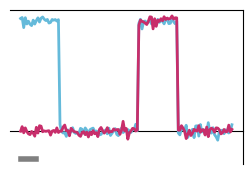

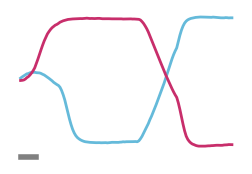

In [16]:
fixation_duration_min = 500
fixation_duration_max = 500
dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.decision_duration = 200
dms.setup()

x1 = dms.generate_dms_data(1, type='A-A')[0]
x2 = dms.generate_dms_data(1, type='B-A')[0]
outp1, traj1 = net1.forward(x1)
outp2, traj2 = net1.forward(x2)
x1, x2 = x1.squeeze().numpy(), x2.squeeze().numpy()
rates1 = np.tanh(traj1.detach().squeeze().numpy())
rates2 = np.tanh(traj2.detach().squeeze().numpy())
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

def time_mapping(t):
    return t * dms.deltaT / 1000

fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(time_mapping(np.arange(x1.shape[0])), x1[:, 0], c='#65BADA', zorder=30, lw=2)
ax.plot(time_mapping(np.arange(x1.shape[0])), x2[:, 0], c='#C82E6B', zorder=30, lw=2)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_visible(False)
#plot_periods(ax)
ax.set(xticks=[], ylim=(-.3, 1.1), yticks=[])
ax.plot([0, 0.2], [-.25, -.25], c='gray', lw=4)
plt.savefig('./outputs/input.svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp1, color='#65BADA', zorder=30, lw=2)
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp2, color='#C82E6B', zorder=30, lw=2)
ax.set_axis_off()
helpers.center_axes(ax)
ax.plot([0, 0.2], [-1.25, -1.25], c='gray', lw=4)
plt.savefig('./outputs/output.svg', bbox_inches='tight')
plt.show()

# Fit Gaussian and sample new networks

In [4]:
n_pops = 2
z1, _ = clustering.gmm_fit(net1, n_pops, algo='bayes', random_state=0)  # z will contain labels for the 2 populations
z2, _ = clustering.gmm_fit(net2, n_pops, algo='bayes', random_state=0)

net1_sampled_1 = clustering.to_support_net(net1, z1)
net1_sampled_2 = clustering.to_support_net(net1, z1)

net2_sampled_1 = clustering.to_support_net(net2, z2)
net2_sampled_2 = clustering.to_support_net(net2, z2)

In [7]:
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
train(net1_sampled_1, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

Training...
initial loss: 1.254
epoch 0:  loss=1.174  (took 3.03 s) *
epoch 1:  loss=1.153  (took 2.96 s) *
epoch 2:  loss=1.181  (took 2.97 s)
epoch 3:  loss=1.119  (took 3.04 s) *
epoch 4:  loss=1.185  (took 2.97 s)
epoch 5:  loss=1.176  (took 2.97 s)
epoch 6:  loss=1.099  (took 2.96 s) *
epoch 7:  loss=1.099  (took 2.96 s) *
epoch 8:  loss=1.143  (took 2.98 s)
epoch 9:  loss=1.162  (took 2.96 s)
epoch 10:  loss=1.146  (took 2.97 s)
epoch 11:  loss=1.174  (took 2.98 s)
epoch 12:  loss=1.112  (took 2.98 s)
epoch 13:  loss=1.214  (took 3.01 s)
epoch 14:  loss=1.147  (took 2.99 s)
epoch 15:  loss=1.139  (took 3.02 s)
epoch 16:  loss=1.203  (took 2.98 s)
epoch 17:  loss=1.163  (took 2.98 s)
epoch 18:  loss=1.056  (took 3.03 s) *
epoch 19:  loss=1.187  (took 3.03 s)


In [8]:
train(net1_sampled_2, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

Training...
initial loss: 1.194
epoch 0:  loss=1.092  (took 3.00 s) *
epoch 1:  loss=1.191  (took 2.99 s)
epoch 2:  loss=1.169  (took 3.05 s)
epoch 3:  loss=1.144  (took 2.99 s)
epoch 4:  loss=1.164  (took 2.97 s)
epoch 5:  loss=1.201  (took 2.96 s)
epoch 6:  loss=1.170  (took 2.98 s)
epoch 7:  loss=1.246  (took 3.00 s)
epoch 8:  loss=1.171  (took 3.00 s)
epoch 9:  loss=1.119  (took 3.03 s)
epoch 10:  loss=1.190  (took 2.99 s)
epoch 11:  loss=1.137  (took 3.00 s)
epoch 12:  loss=1.139  (took 3.14 s)
epoch 13:  loss=1.217  (took 3.10 s)
epoch 14:  loss=1.163  (took 3.04 s)
epoch 15:  loss=1.138  (took 3.01 s)
epoch 16:  loss=1.148  (took 3.02 s)
epoch 17:  loss=1.132  (took 3.00 s)
epoch 18:  loss=1.210  (took 3.01 s)
epoch 19:  loss=1.101  (took 2.99 s)


# Visualising two network populations

pop 0: slope=0.06, intercept=0.02
pop 1: slope=-0.24, intercept=-0.18
pop 0: slope=-0.01, intercept=-0.05
pop 1: slope=0.04, intercept=-0.01
pop 0: slope=0.03, intercept=0.17
pop 1: slope=-0.06, intercept=-0.22
pop 0: slope=0.74, intercept=0.00
pop 1: slope=0.70, intercept=0.08
pop 0: slope=-0.08, intercept=0.01
pop 1: slope=0.05, intercept=0.07
pop 0: slope=-0.01, intercept=-0.14
pop 1: slope=0.04, intercept=-0.05
pop 0: slope=-0.06, intercept=-0.32
pop 1: slope=0.09, intercept=0.38
pop 0: slope=0.72, intercept=-0.03
pop 1: slope=0.13, intercept=0.54


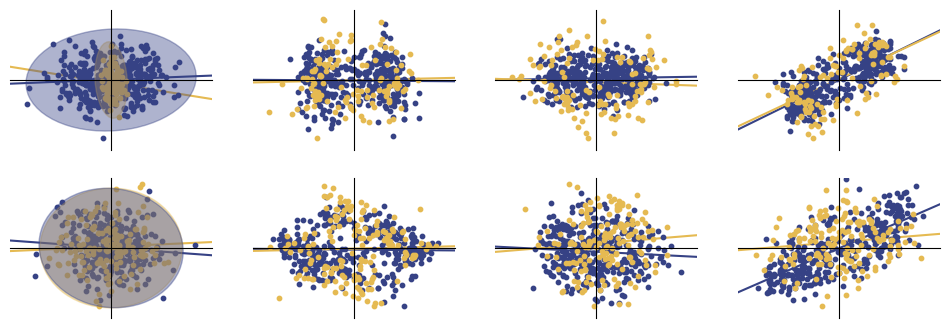

In [119]:
# Visualizing those 2 populations
m11 = net1.m[:,0].detach().numpy()
n11 = net1.n[:,0].detach().numpy() 
m12 = net1.m[:,1].detach().numpy()
n12 = net1.n[:,1].detach().numpy() 
wi11 = net1.wi[0].detach().numpy()
wi12 = net1.wi[1].detach().numpy()

m21 = net2.m[:,0].detach().numpy()
n21 = net2.n[:,0].detach().numpy() 
m22 = net2.m[:,1].detach().numpy()
n22 = net2.n[:,1].detach().numpy() 
wi21 = net2.wi[0].detach().numpy()
wi22 = net2.wi[1].detach().numpy()

fig, ax = plt.subplots(2, 4, figsize=(12, 4))
colors = ['#364285', '#E5BA52']
fs = 12
clustering.pop_scatter_linreg(wi11, wi12, z1, n_pops, colors=colors, ax=ax[0,0])
plot_ellipse(ax[0,0], np.array([wi11[z1.astype(bool)], wi12[z1.astype(bool)]]).T, std_factor=3, color=colors[1])
plot_ellipse(ax[0,0], np.array([wi11[~z1.astype(bool)], wi12[~z1.astype(bool)]]).T, std_factor=3, color=colors[0])

clustering.pop_scatter_linreg(m11, m12, z1, n_pops, colors=colors, ax=ax[0,1])
clustering.pop_scatter_linreg(n11, n12, z1, n_pops, colors=colors, ax=ax[0,2])
clustering.pop_scatter_linreg(m11, n11, z1, n_pops, colors=colors, ax=ax[0,3])

clustering.pop_scatter_linreg(wi21, wi22, z2, n_pops, colors=colors, ax=ax[1,0])
plot_ellipse(ax[1,0], np.array([wi21[z1.astype(bool)], wi22[z1.astype(bool)]]).T, std_factor=3, color=colors[1])
plot_ellipse(ax[1,0], np.array([wi21[~z1.astype(bool)], wi22[~z1.astype(bool)]]).T, std_factor=3, color=colors[0])

clustering.pop_scatter_linreg(m21, m22, z2, n_pops, colors=colors, ax=ax[1,1])
clustering.pop_scatter_linreg(n21, n22, z2, n_pops, colors=colors, ax=ax[1,2])
clustering.pop_scatter_linreg(m21, n21, z2, n_pops, colors=colors, ax=ax[1,3])

plt.savefig('./outputs/GNN_parameter_distribution.svg')

pop 0: slope=0.08, intercept=-0.00
pop 1: slope=0.36, intercept=-0.00
pop 0: slope=0.06, intercept=-0.04
pop 1: slope=0.55, intercept=0.03


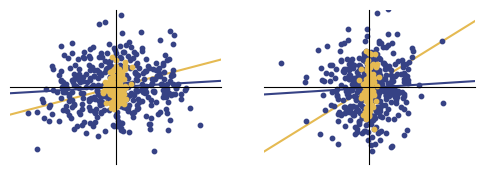

In [128]:
wi11 = net1_sampled_1.wi[0].detach().numpy()
wi12 = net1_sampled_1.wi[1].detach().numpy()
wi21 = net1_sampled_2.wi[0].detach().numpy()
wi22 = net1_sampled_2.wi[1].detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
colors = ['#364285', '#E5BA52']
fs = 12
z, _ = clustering.gmm_fit(net1_sampled_1, n_pops, algo='bayes', random_state=0)
clustering.pop_scatter_linreg(wi11, wi12, z, n_pops, colors=colors, ax=ax[0])
z, _ = clustering.gmm_fit(net1_sampled_2, n_pops, algo='bayes', random_state=0)
clustering.pop_scatter_linreg(wi21, wi22, z, n_pops, colors=colors, ax=ax[1])
plt.savefig('./outputs/GNN_parameter_distribution_resample.svg')


# Design input

In [9]:
n_gains=20
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = np.linspace(1,0,n_gains)
    
input = torch.zeros(n_gains, decision, 2)
for i, g in enumerate(gain):
    input[i, stim1_begin:stim1_end, 0] = g
    input[i, stim2_begin:stim2_end, 0] = g

# Plot phase portraits of two different dynamics  

In [63]:
n_traj=100

traj11 = generate_trajectories(net1_sampled_1, input, epochs, n_traj, fname='./outputs/RNN_trajectories11.pkl')
traj12 = generate_trajectories(net1_sampled_2, input, epochs, n_traj, fname='./outputs/RNN_trajectories12.pkl')
traj21 = generate_trajectories(net2_sampled_1, input, epochs, n_traj, fname='./outputs/RNN_trajectories21.pkl')
traj22 = generate_trajectories(net2_sampled_2, input, epochs, n_traj, fname='./outputs/RNN_trajectories22.pkl')

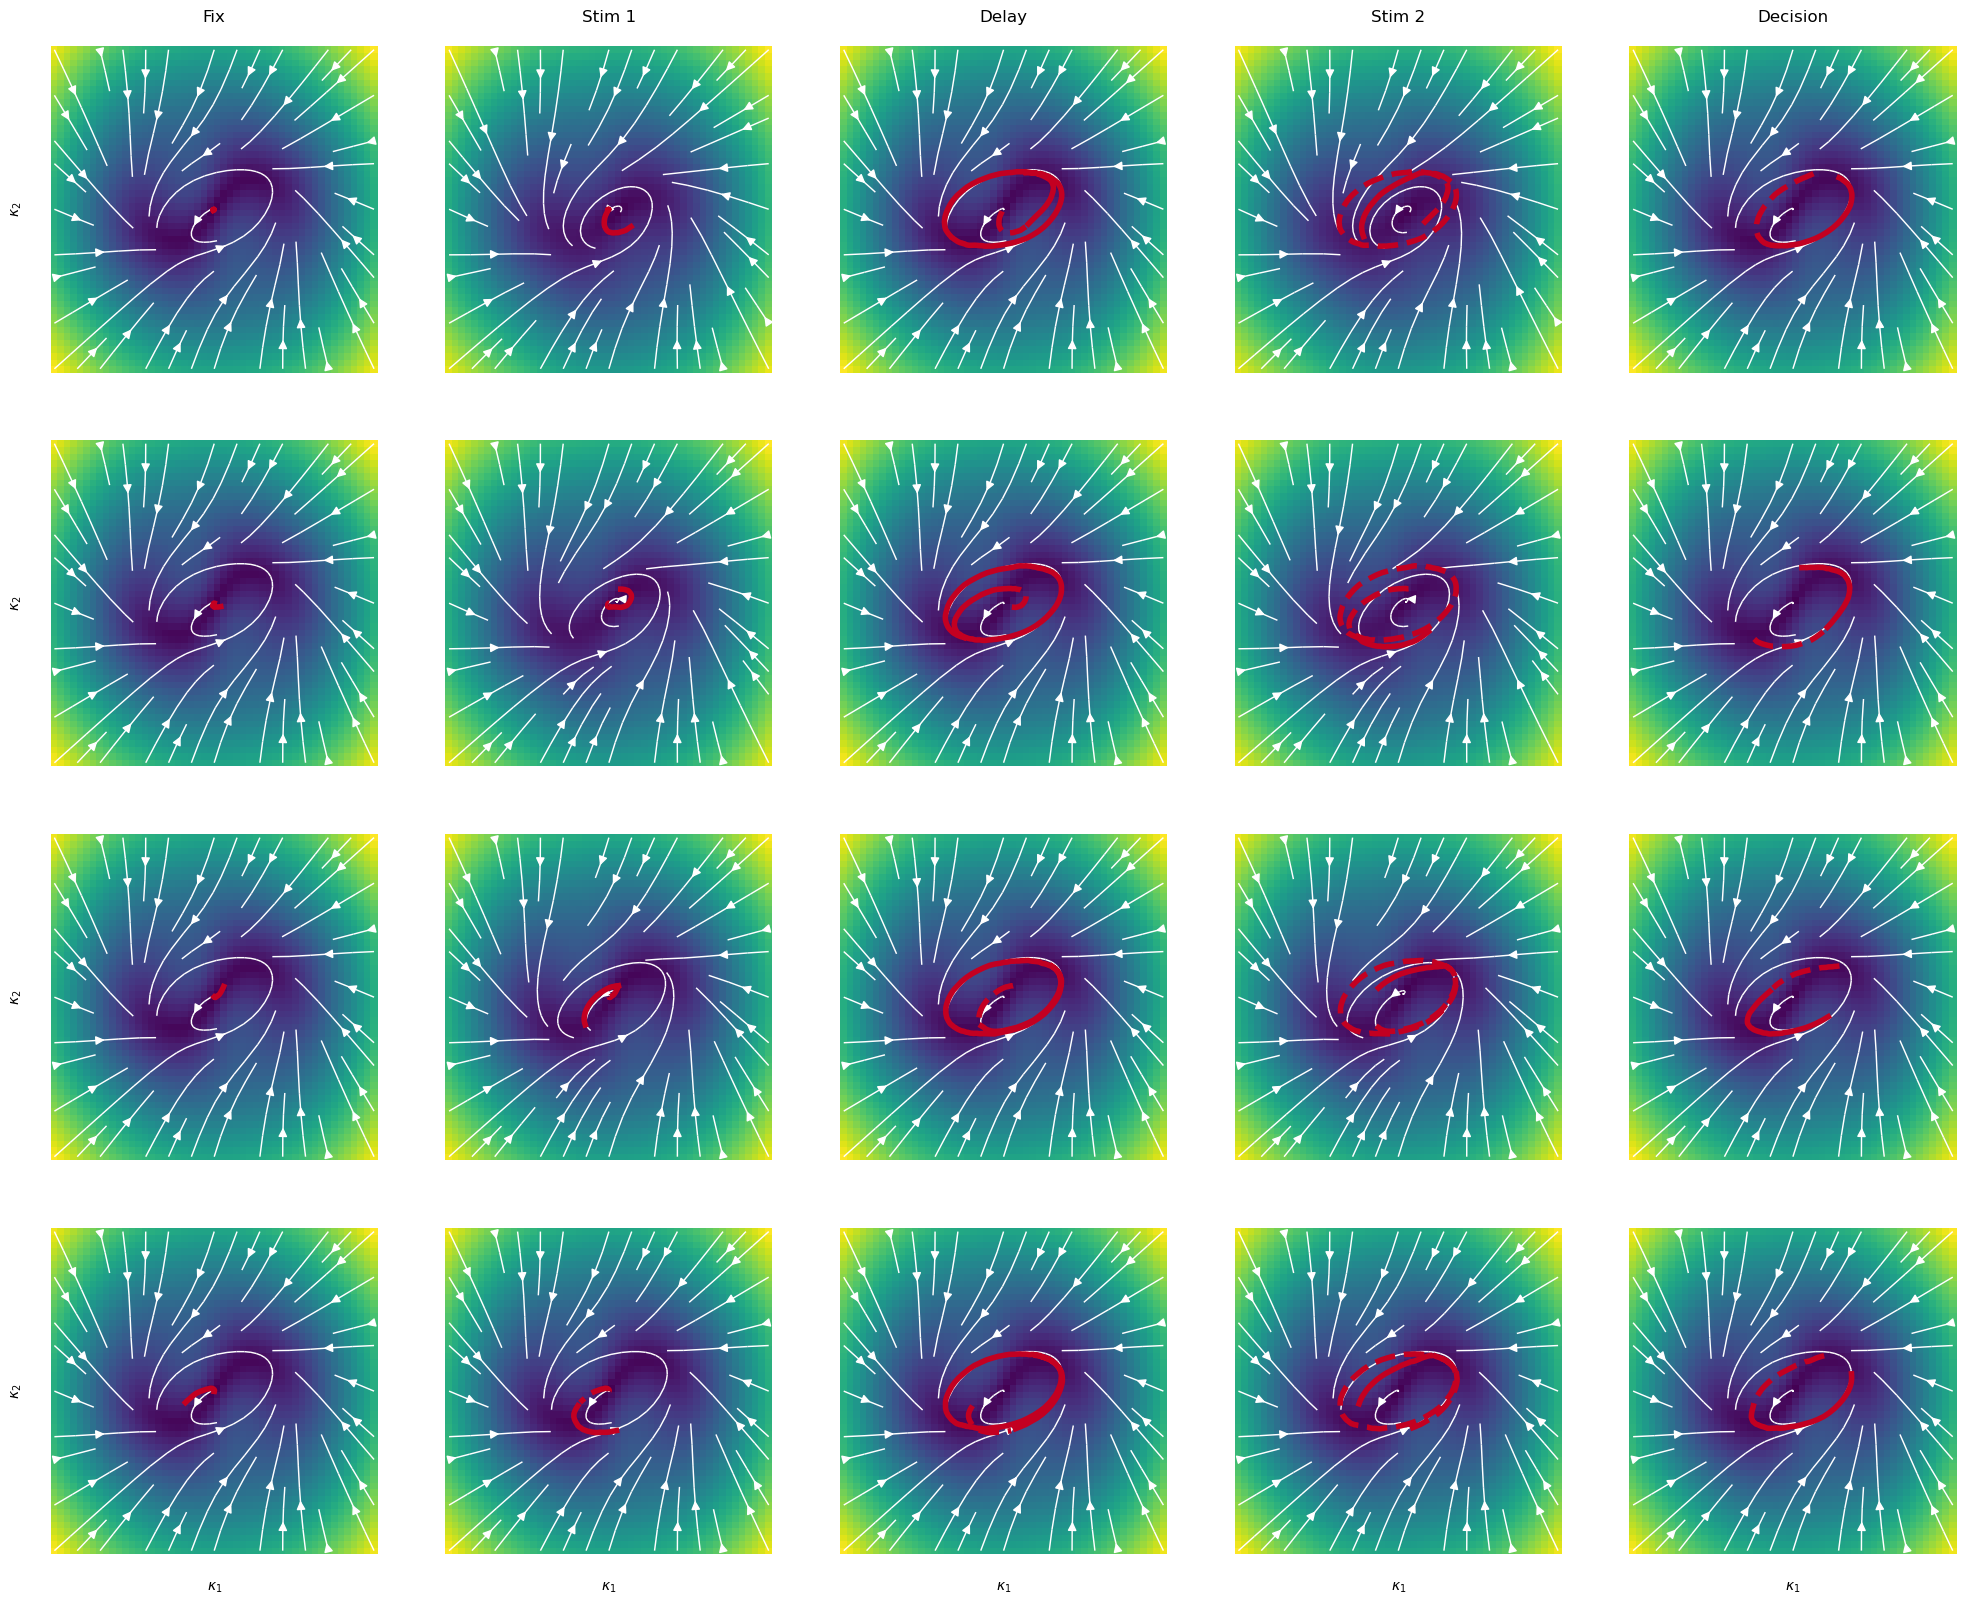

In [148]:
plot_experiment(net1_sampled_2, input, traj12, epochs, rect=(-6, 6, -4, 4), traj_to_show=1)

#plt.savefig('./outputs/fields_all_conditions.svg')

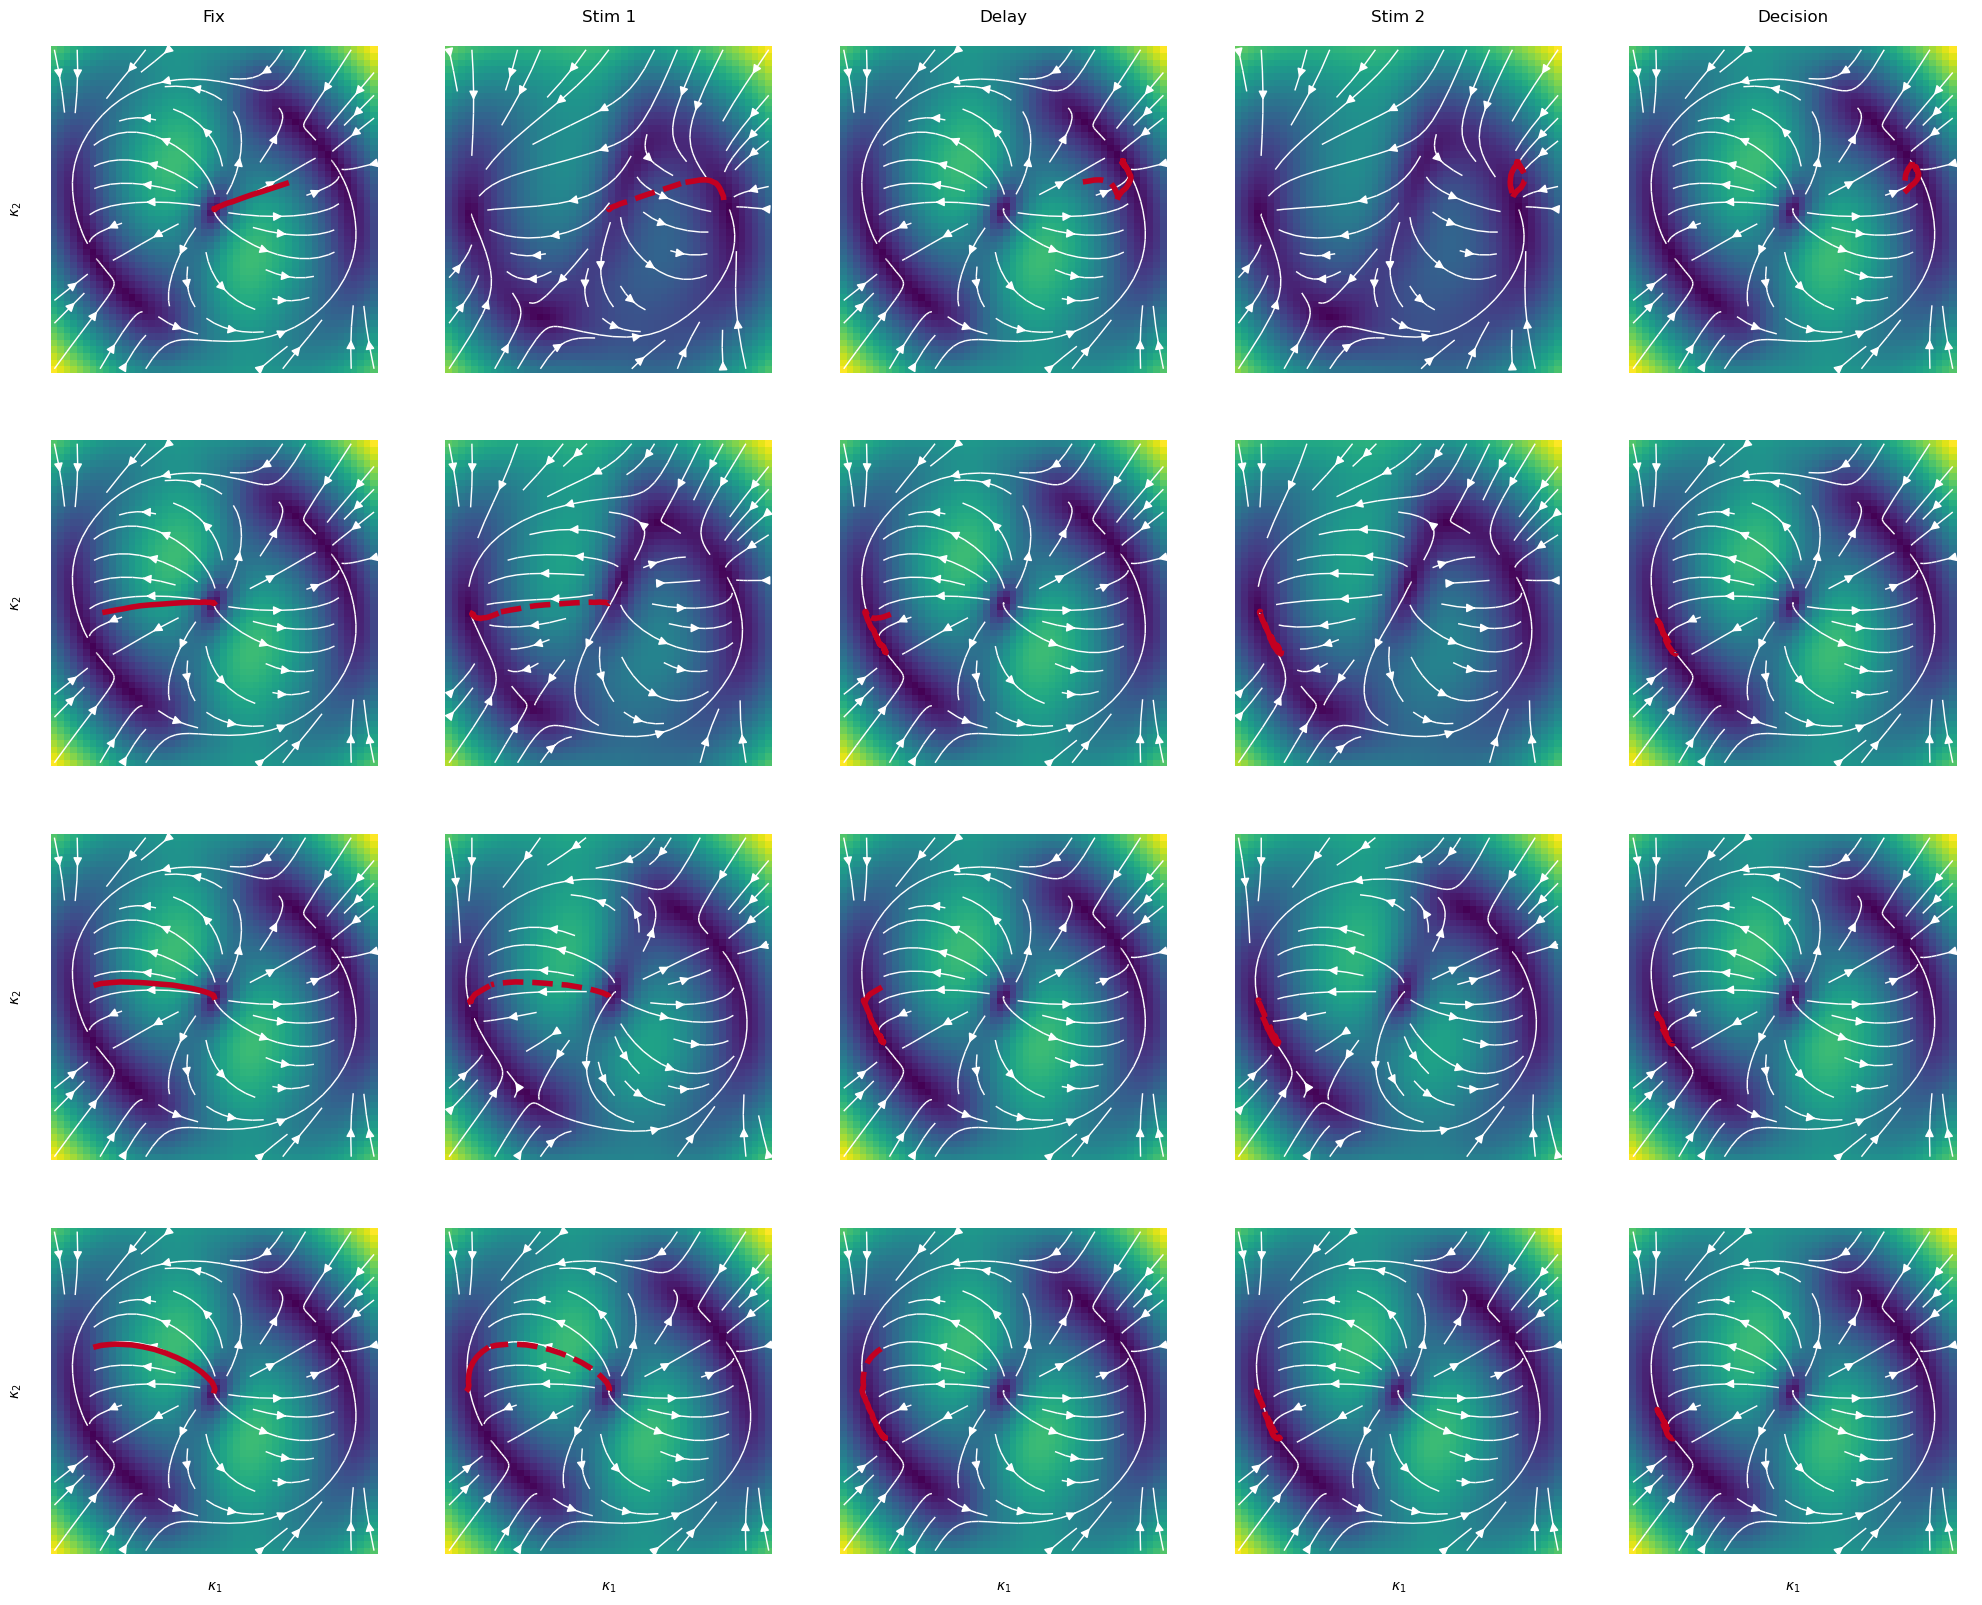

In [13]:
plot_experiment(net2_sampled_2, input, traj22, epochs, rect=(-6, 6, -4, 4), traj_to_show=1)
#plt.savefig('./outputs/fields_all_conditions_2.svg')

# Concatenate data and create dataset

In [64]:
transient=10
pos11, vel11 = aggregate_data(traj11, epochs, transient)

In [65]:
data = utils.construct_dataset(pos11, features=vel11, graph_type='cknn', k=15, stop_crit=0.01, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3


Vector computations are disabled

---- Computing kernels ... Done 


In [66]:
par = {'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 4,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data, use_best=True)


---- Settings: 

epochs : 40
order : 2
hidden_channels : 32
out_channels : 4
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  698

---- Training network ...

Epoch: 1, Training loss: 1.3464, Validation loss: 1.2366, lr: 0.0100 *
Epoch: 2, Training loss: 1.1222, Validation loss: 1.1552, lr: 0.0100 *
Epoch: 3, Training loss: 1.1043, Validation loss: 1.1264, lr: 0.0100 *
Epoch: 4, Training loss: 1.1031, Validation loss: 1.1386, lr: 0.0100
Epoch: 5, Training loss: 1.0821, Validation loss: 1.1203, lr: 0.0100 *
Epoch: 6, Training loss: 1.0808, Validation loss: 1.1275, lr: 0.0100
Epoch: 7, Training loss: 1.0717, Validation loss: 1.1266, lr: 0.0100
Epoch: 8, Training loss: 1.0671, Validation loss: 1.1107, lr

Performed umap embedding on embedded results.


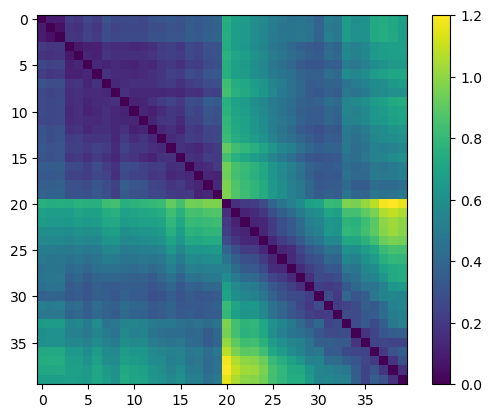

In [67]:
data = model.evaluate(data)
data = postprocessing(data, n_clusters=40)

im = plt.imshow(data.dist)
plt.colorbar(im)

Performed MDS embedding on embedded results.


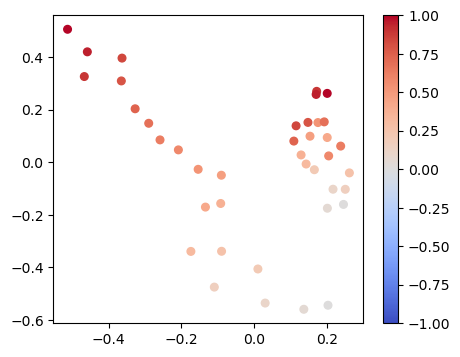

In [74]:
labels = [g for i in range(2) for g in gain ]

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot()
emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
ax = plotting.embedding(emb_MDS, labels, ax=ax, s=30, alpha=1, axes_visible=True)
plt.savefig('./outputs/stimulus_vs_no_stimulus.svg')

In [139]:
transient=10
pos11, vel11 = aggregate_data(traj11, epochs, transient, only_stim=True)
pos12, vel12 = aggregate_data(traj12, epochs, transient, only_stim=True)

pos21, vel21 = aggregate_data(traj21, epochs, transient, only_stim=True)
pos22, vel22 = aggregate_data(traj22, epochs, transient, only_stim=True)

pos = pos11 + pos12 + pos21# + pos22
vel = vel11 + vel12 + vel21# + vel22

In [144]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=15, stop_crit=0.01, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3


Vector computations are disabled

---- Computing kernels ... Done 


In [145]:
par = {'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 4,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data, use_best=True)


---- Settings: 

epochs : 40
order : 2
hidden_channels : 32
out_channels : 4
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  698

---- Training network ...

Epoch: 1, Training loss: 1.3410, Validation loss: 1.2554, lr: 0.0100 *
Epoch: 2, Training loss: 1.1393, Validation loss: 1.1330, lr: 0.0100 *
Epoch: 3, Training loss: 1.0902, Validation loss: 1.1188, lr: 0.0100 *
Epoch: 4, Training loss: 1.0826, Validation loss: 1.0913, lr: 0.0100 *
Epoch: 5, Training loss: 1.0761, Validation loss: 1.1203, lr: 0.0100
Epoch: 6, Training loss: 1.0710, Validation loss: 1.1015, lr: 0.0100
Epoch: 7, Training loss: 1.0715, Validation loss: 1.0990, lr: 0.0100
Epoch: 8, Training loss: 1.0633, Validation loss: 1.0826, lr

Performed umap embedding on embedded results.


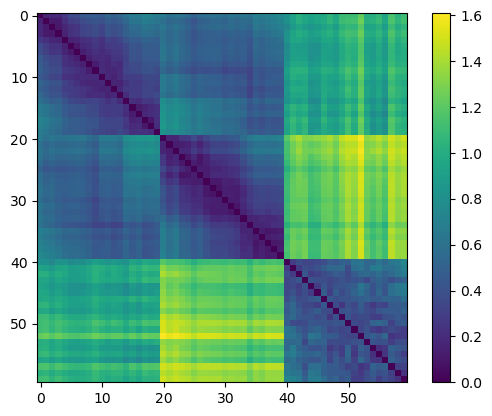

In [146]:
data = model.evaluate(data)
data = postprocessing(data, n_clusters=40)

im = plt.imshow(data.dist)
plt.colorbar(im)

Performed MDS embedding on embedded results.


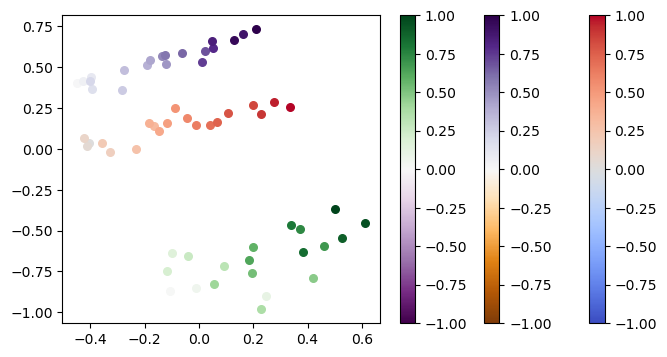

In [147]:
n = len(data.dist)//3
labels = [g for g in gain ]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()#projection="3d")
emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')#, dim_emb=3)
ax = plotting.embedding(emb_MDS[:n], labels, ax=ax, s=30, alpha=1, axes_visible=True)
ax = plotting.embedding(emb_MDS[n:2*n], labels, ax=ax, s=30, alpha=1, axes_visible=True, cmap='PuOr')
ax = plotting.embedding(emb_MDS[2*n:], labels, ax=ax, s=30, alpha=1, axes_visible=True, cmap='PRGn')

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]
labels = np.hstack([gain,gain])
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)

# Create new network by fitting Gaussian mixture to the connectivity space

Check that the resampled networks still give the same validation losses

In [ ]:
accs2 = []
for _ in range(10):
    net_sampled.resample_basis()
    loss, acc = dms.test_dms(net_sampled, x_val, y_val, mask_val)
    accs2.append(acc)